In [1]:
%load_ext autoreload 

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

Consider the following boundary value problem:
\begin{align}
    \frac{d T_1}{d_A} =& -q,\ T_1(0) = T_{1,0} \\
    \frac{d T_2}{d_A} =& -\frac{1}{2}q,\ T_2(A_{hx}) = T_{2,A_{hx}} \\
\end{align}
where $q = (T_1 - T_2)U$.

This boundary value problem describes a counter current heat exchanger; a hot liquid enters a device and exchanges heat across a metal plate with a cold liquid traveling through the device in the opposite direction. Here, $T_1$ is the temperature of the hot stream, $T_2$ is the temperature of the cold stream, $q$ is the rate of heat transfer from the hot fluid to the cold fluid, $U$ is the overall heat transfer coefficient and $A_hx$ is the total area of the heat exchanger.

In [20]:
# define some variables
A, T1, T2 = sym.symbols('A, T1, T2')

# define some parameters
U, T10, T2Ahx = sym.symbols('U, T10, T2Ahx')

# define functional form
q = (T1 - T2) * U
rhs = {'T1': -q, 'T2': -0.5 * q}

# define some boundary conditions
bcs = {'lower': [T1 - T10], 'upper': [T2 - T2Ahx]}

# provide numerical values for the parameters
params = {'T10': 130, 'T2Ahx': 70, 'Ahx': 5.0, 'U': 1.0}

In [21]:
heat_exchanger = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['T1', 'T2'],
                                                            independent_var='A',
                                                            rhs=rhs,
                                                            boundary_conditions=bcs,
                                                            params=params)

In [22]:
heat_exchanger_solver = pycollocation.OrthogonalPolynomialSolver(heat_exchanger)

In [23]:
# specify an initial guess
domain = [0, params['Ahx']]
ts = np.linspace(domain[0], domain[1], 1000)
T1s = np.repeat(0.5 * (params['T10'] + params['T2Ahx']), 1000)
initial_T1_poly = np.polynomial.Chebyshev.fit(ts, T1s, 15, domain)

initial_coefs = {'T1': initial_T1_poly.coef, 'T2': initial_T1_poly.coef}

In [24]:
heat_exchanger_solver.solve(kind="Chebyshev",
                            coefs_dict=initial_coefs,
                            domain=domain)


In [25]:
heat_exchanger_solution = pycollocation.Solution(heat_exchanger_solver)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10c046cd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10c46fbd0>], dtype=object)

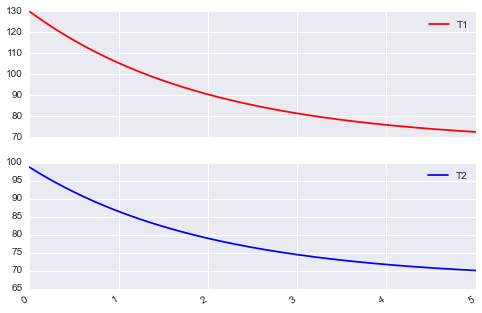

In [26]:
heat_exchanger_solution.interpolation_knots = np.linspace(0, params['Ahx'], 1000)
heat_exchanger_solution.solution.plot(subplots=True, style=['r', 'b'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10c53c6d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10c7ba510>], dtype=object)

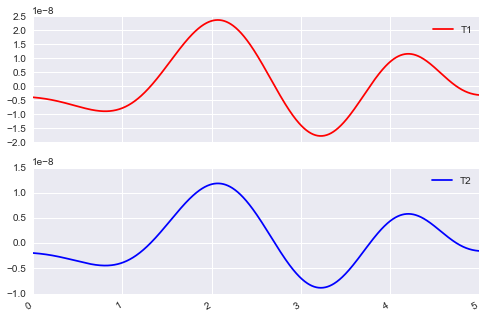

In [27]:
heat_exchanger_solution.residuals.plot(subplots=True, style=['r', 'b'])
